### Column integrated nudging tendencies

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import xarray as xr
import fsspec
import cftime
import intake
import vcm

from vcm import  mass_integrate
from vcm.calc.thermo import column_integrated_heating_from_isochoric_transition, minus_column_integrated_moistening, latent_heat_vaporization
from fv3viz import plot_cube, mappable_var

N2F_TENDENCIES_PATH = "gs://vcm-ml-experiments/2021-04-13-n2f-c3072/3-hrly-ave-rad-precip-setting-30-min-rad-timestep-shifted-start-tke-edmf/nudging_tendencies.zarr"
MAPPABLE_VAR_KWARGS = {
    "coord_x_center": "x",
    "coord_y_center": "y",
    "coord_x_outer": "x_interface",
    "coord_y_outer": "y_interface",
    "coord_vars": {
        "lonb": ["y_interface", "x_interface", "tile"],
        "latb": ["y_interface", "x_interface", "tile"],
        "lon": ["y", "x", "tile"],
        "lat": ["y", "x", "tile"],
    },
}

n2f_tendencies = intake.open_zarr(N2F_TENDENCIES_PATH).to_dask()

#### moist static energy nudging tendency $ \langle nQ_{MSE} \rangle =    \langle  nQ1 \rangle + L_{v}  \langle nQ2 \rangle$
$<nQ1>$ heating is for constant volume

In [2]:
Cp =  1004.
Rd = 287.05
Cv = Cp - Rd

def moist_static_energy_tendency(T: xr.DataArray, dQ1: xr.DataArray, dQ2: xr.DataArray): 
    return Cv * dQ1 + latent_heat_vaporization(T) * dQ2

#### nudged to fine wind tendencies are on the interfaces, need to center and rotate

In [5]:
from vcm.catalog import catalog
wind_rotation_matrix = catalog["wind_rotation/c48"].read()
grid=catalog["grid/c48"].read()

In [6]:
n2f_tendencies["dQu"], n2f_tendencies["dQv"] = vcm.cubedsphere.center_and_rotate_xy_winds(
    wind_rotation_matrix,
    n2f_tendencies["x_wind_tendency_due_to_nudging"],
    n2f_tendencies["y_wind_tendency_due_to_nudging"],
)

#### Need the pressure level thicknesses

In [7]:
n2f_state = intake.open_zarr("gs://vcm-ml-experiments/2021-04-13-n2f-c3072/3-hrly-ave-rad-precip-setting-30-min-rad-timestep-shifted-start-tke-edmf/state_after_timestep.zarr").to_dask().sel(time=n2f_tendencies.time)
n2f_tendencies["pressure_thickness_of_atmospheric_layer"] = n2f_state["pressure_thickness_of_atmospheric_layer"]
n2f_tendencies["air_temperature"] = n2f_state["air_temperature"]

In [9]:

n2f_tendencies["column_integrated_dQu"] = mass_integrate(
    n2f_tendencies["dQu"],
    n2f_tendencies["pressure_thickness_of_atmospheric_layer"],
    dim="z"
).mean("time").load()
 
n2f_tendencies["column_integrated_dQv"] = mass_integrate(
    n2f_tendencies["dQv"],
    n2f_tendencies["pressure_thickness_of_atmospheric_layer"],
    dim="z"
).mean("time").load()


In [10]:
n2f_tendencies["column_integrated_heating_from_isochoric_transition"] = column_integrated_heating_from_isochoric_transition(
    n2f_tendencies["air_temperature_tendency_due_to_nudging"],
    n2f_tendencies["pressure_thickness_of_atmospheric_layer"],
).mean("time").load()


In [11]:
n2f_tendencies["column_integrated_drying"] = minus_column_integrated_moistening(
    n2f_tendencies["specific_humidity_tendency_due_to_nudging"],
    n2f_tendencies["pressure_thickness_of_atmospheric_layer"],
).mean("time").load()



In [12]:

n2f_tendencies["column_integrated_mse_tendency"] = mass_integrate(
    moist_static_energy_tendency(n2f_tendencies["air_temperature"], n2f_tendencies["air_temperature_tendency_due_to_nudging"], n2f_tendencies["specific_humidity_tendency_due_to_nudging"]),
    n2f_tendencies["pressure_thickness_of_atmospheric_layer"],
    dim="z"
).mean("time").load()
                      
       

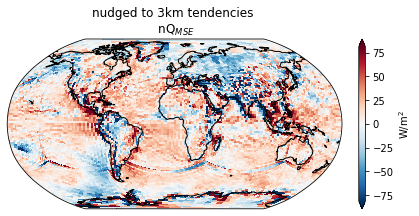

In [22]:

plot_cube(
    mappable_var(
        xr.merge([n2f_tendencies["column_integrated_mse_tendency"], grid]),
        "column_integrated_mse_tendency",
        **MAPPABLE_VAR_KWARGS,
    ),
    cbar_label="W/m$^2$"
    
)
plt.title("nudged to 3km tendencies \n nQ$_{MSE}$")
plt.savefig("figures/nudging_column_int_nQmse_time_mean.png", bbox_inches = "tight")

#### Column integrated heating (isochoric transition- this is how it is reported in prognostic run diags)


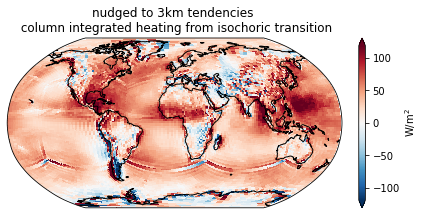

In [13]:
plot_cube(
    mappable_var(
        xr.merge([n2f_tendencies["column_integrated_heating_from_isochoric_transition"], grid]),
        "column_integrated_heating_from_isochoric_transition",
        **MAPPABLE_VAR_KWARGS,
    ),
    cbar_label="W/m$^2$"
    
)
plt.title("nudged to 3km tendencies \n column integrated heating from isochoric transition")
plt.savefig("figures/nudging_column_int_isochoric_heating_time_mean.png", bbox_inches = "tight")

#### Column integrated drying 

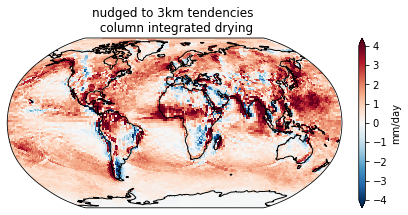

In [14]:
plot_cube(
    mappable_var(
        xr.merge([n2f_tendencies["column_integrated_drying"], grid]),
        "column_integrated_drying",
        **MAPPABLE_VAR_KWARGS,
    ),
    cbar_label="mm/day",
    vmax=4
    
)
plt.title("nudged to 3km tendencies \n column integrated drying")
plt.savefig("figures/nudging_column_int_drying_time_mean.png",bbox_inches = "tight")

#### Column integrated dQu [Pa]: Nudge to obs (top) vs nudge to fine (bottom)

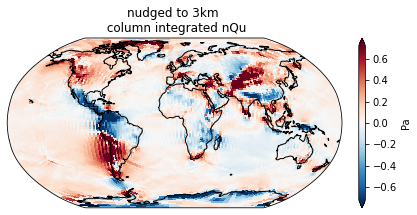

In [15]:
plot_cube(
    mappable_var(
        xr.merge([n2f_tendencies["column_integrated_dQu"], grid]),
        "column_integrated_dQu",
        **MAPPABLE_VAR_KWARGS,
    ),
    cbar_label="Pa"
    
)
plt.title("nudged to 3km \n column integrated nQu")
plt.savefig("figures/nudging_column_int_eastwind_time_mean.png", bbox_inches = "tight")